In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import monthrange
import json

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [86]:
class csvData:
    def __init__(self, path = None, temperaturePath = None):
        if(path != None):
            self.data = pd.read_csv(path)
            self.dates = np.array(sorted(self.data["urg_ddeb"], reverse = True))
        if(temperaturePath != None):
            try:
                with open(temperaturePath, "r") as f:
                    self.temperatures = json.load(f)
            except:
                raise("Temperatures path not found !!")
        self.weights = [2, 0.5, 0.25, 0.05]
        self.deltaT = 1
    
#     # sub <= 600
    def timeSubstraction(self, strDate, sub):
        dt = datetime.strptime(strDate, '%Y-%m-%d %H:%M:%S')
        year, month, day, hour, minute, second = dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second
        minute -= sub
        if(minute < 0):
            hour += minute//60
            minute = (minute - 60*(minute//60)) % 60
        if(hour < 0):
            day += hour//24
            hour = (hour - 24*(hour//24)) % 24
        if(day < 1):
            month -= 1
            if(month < 1):
                month += 12
                year -= 1
            day += monthrange(year, month)[1]
        return datetime(year, month, day, hour, minute, second)
    
    def computeSlope(self, index):
        return (2*self.countArrivals(index, self.deltaT*60) - self.countArrivals(index, 2*self.deltaT*60))/self.deltaT
    
    def countArrivals(self, currentIndex, sub):
        timePriorArrivals = self.timeSubstraction(self.dates[currentIndex], sub)
        strTimePriorArrivals = datetime.strftime(timePriorArrivals, '%Y-%m-%d %H:%M:%S')
        i = 0
        while(self.dates[i+currentIndex] >= strTimePriorArrivals and self.dates.shape[0] > i+currentIndex):
            i += 1
        return i
    
    def parseHourOfDay(self, h, d, m, y):
        l = False
        count = 0
        for _ in range(self.data.shape[0]):
            date = datetime.strptime(self.dates[_], '%Y-%m-%d %H:%M:%S')
            if(l or (date.hour == h and date.day == d and date.month == m and date.year == y)):
                l = True
                if(date.hour == h and date.day == d):
                    count += 1
                else:
                    break
        return count
    
    
    def parseHourlyDays(self, i, numOfHours = 1):   # i: index end of hour
        date = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S')
        countHours = 0
        df = pd.DataFrame()
        count = 1
        while(countHours < numOfHours):
            i += 1
            dt = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S')
            if(dt.hour == date.hour and dt.day == date.day and date.month == dt.month and date.year == dt.year):
                count += 1
            else:
                countHours += abs(date.hour - dt.hour)
                date = dt # datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S')
                currentDf = self.featureGen(i-1)
                currentDf["y"] = count
                df = df.append(currentDf)
                count = 1
        return df
    
    def countCensus(self, currentIndex, sub):
        timePriorCensus = self.timeSubstraction(self.dates[currentIndex], sub)
        strTimePriorCensus = datetime.strftime(timePriorCensus, '%Y-%m-%d %H:%M:%S')
        i = 0
        while(self.dates[i+currentIndex] >= strTimePriorCensus and self.dates.shape[0] > i+currentIndex):
            i += 1
        indexStartDay = self.findStartDay(timePriorCensus.year, timePriorCensus.month, timePriorCensus.day)
        
        return indexStartDay - currentIndex - i
    
    def featureGen(self, i):
        date = self.dates[i]
        dateTime = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        weekend_flag = int(dateTime.weekday() == 5 or dateTime.weekday() == 6)
        evening_flag = int(dateTime.hour > 20 or dateTime.hour < 8)

        hourOfDay = dateTime.hour
        dayOfWeek = dateTime.weekday()
        monthOfYear = dateTime.month
        quarterOfYear = (dateTime.month-1)//4 + 1
        priorArrivals = self.countArrivals(i, 15)*self.weights[0] + \
                        (self.countArrivals(i, 30))*self.weights[1] + \
                        (self.countArrivals(i, 45))*self.weights[2] + \
                        (self.countArrivals(i, 60))*self.weights[3]
        slope = self.computeSlope(i)
        return pd.DataFrame({'slope': [slope],
                             'priorArrivals':[priorArrivals],
                             'hourOfDay': [hourOfDay],
                             'dayOfWeek':[dayOfWeek],
                             'monthOfYear':[monthOfYear],
                             'quarterOfYear':[quarterOfYear],
                             'evening_flag':[evening_flag],
                             'weekend_flag':[weekend_flag]})
    
    def parseDays(self, start, end):
        df = pd.DataFrame()
        for i in range(start, end):
            year = datetime.strptime(self.dates[i],"%Y-%m-%d %H:%M:%S").year
            month = datetime.strptime(self.dates[i],"%Y-%m-%d %H:%M:%S").month
            day = datetime.strptime(self.dates[i],"%Y-%m-%d %H:%M:%S").day
            hour = datetime.strptime(self.dates[i],"%Y-%m-%d %H:%M:%S").hour
            dfRow = self.featureGen(i)
            dfRow["t(°C)"] = self.temperatures.get(f"{year}-{month:02d}-{day:02d} {hour:02d}-00")
            df = df.append(dfRow)
        return df
        
    def findStartMonth(self, y, m):
        foundMonth = False
        for i in range(self.dates.shape[0]):
            month = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').month
            year = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').year
            if(month == m and year == y):
                foundMonth = True
            if(foundMonth and m != month):
                return i - 1
        return -1
    
    def findEndMonth(self, y, m):
        for i in range(self.dates.shape[0]):
            month = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').month
            year = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').year
            if(month == m and year == y):
                return i
        return -1
    
    def findStartHour(self, d, m, y, h):
        foundHour = False
        for i in range(self.dates.shape[0]):
            day = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').day
            month = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').month
            year = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').year
            hour = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').hour
            if(day == d and month == m and year == y and hour == h):
                foundHour = True
            if(foundHour and (day != d or hour != h)):
                return i - 1
        return -1
    
    def findStartDay(self, y, m, d):
        foundDay = False
        for i in range(self.dates.shape[0]):
            day = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').day
            month = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').month
            year = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').year
            if(day == d and month == m and year == y):
                foundDay = True
            if(foundDay and day != d):
                return i - 1
        return -1
    
    def findEndDay(self, y, m, d):
        for i in range(self.dates.shape[0]):
            day = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').day
            month = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').month
            year = datetime.strptime(self.dates[i], '%Y-%m-%d %H:%M:%S').year
            if(day == d and month == m and year == y):
                return i
        return -1
    
    def plotDailyVolume(self, d, m, y, period = 1):
        days = {0:"monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
        current_day, current_month, current_year = d, m, y
        l = False
        end_day = 0
        hours = [0]*24
        for _ in range(self.data.shape[0]):
            date = datetime.strptime(self.dates[_], '%Y-%m-%d %H:%M:%S')
            if(l or (date.day == d and date.month == m and date.year == y)):
                l = True
                if(date.day == current_day):
                    hours[date.hour] += 1
                else:
                    plt.plot(hours, label = str(days[(date.weekday()-1)%7]) + f"{str(date.month)}-{str(current_day)}-{str(date.year)}")
                    plt.legend()
                    end_day += 1
                    current_day, current_month, current_year = date.day, date.month, date.year
                    if(end_day == period):
                        break
                    hours = [0]*24
                    hours[date.hour] += 1
    
    def dailyVolume(self, d, m, y):
        hours = [0]*24
        l = False
        for _ in range(self.data.shape[0]):
            date = datetime.strptime(self.dates[_], '%Y-%m-%d %H:%M:%S')
            if(l or (date.day == d and date.month == m and date.year == y)):
                l = True
                if(date.day == d):
                    hours[date.hour] += 1
                else:
                    break
        return hours

In [87]:
# function that split data to train and validation set
def trainVal_Gen(df):
    cols = df.columns
    X, y = np.array(df["hourOfDay"]), np.array(df[cols[-1]])
    X_train, X_val, y_train, y_val = train_test_split(X, y)
    return  X_train, X_val, y_train, y_val

In [88]:
dataClass = csvData("../data/sample urgence1.csv")

In [89]:
# return 90 days of data
n_TrainingDay = 90
trainValData = dataClass.parseHourlyDays(0, n_TrainingDay*24)
X_train, X_val, y_train, y_val = trainVal_Gen(trainValData)

In [91]:
# create test set
test_d, test_m, test_y = 4, 5, 2020
X_test, y_test = np.array([i for i in range(24)]), dataClass.dailyVolume(test_d, test_m, test_y)

In [92]:
gbr = GradientBoostingRegressor(max_depth = 8, n_estimators=5, learning_rate=0.5)
gbr.fit(X_train.reshape(-1, 1), y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=8, n_estimators=5)

In [94]:
predictions = gbr.predict(X_test.reshape(-1, 1))

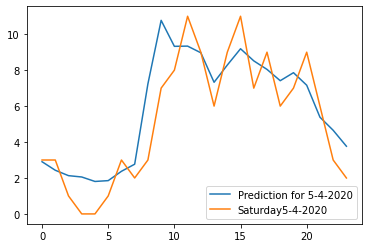

In [97]:
plt.plot(X_test, predictions, label = f"Prediction for {test_m}-{test_d}-{test_y}")
dataClass.plotDailyVolume(test_d, test_m, test_y)

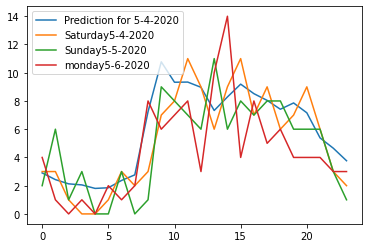

In [98]:
plt.plot(X_test, predictions, label = f"Prediction for {test_m}-{test_d}-{test_y}")
dataClass.plotDailyVolume(test_d, test_m, test_y)
dataClass.plotDailyVolume(test_d+1, test_m, test_y)
dataClass.plotDailyVolume(test_d+2, test_m, test_y)